In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = (12,7)
sns.set()

---
## Create fake data; for this example, we'll use:
<ul>
    <li>between-well spacing,
    <li>completion fluid volume, and 
    <li>completion sand volume.
</ul>

---

In [2]:
# add several fake well packages at various spacings:
spacing = np.concatenate([np.repeat(440, 12), 
                          np.repeat(660, 8),
                          np.repeat(880, 6), 
                          np.repeat(1056, 10),
                          np.repeat(1320, 8),
                          np.repeat(2640, 1)])

# add small random noise to the individual wells spacings:
spacing = spacing * np.random.normal(1, .1, len(spacing), )

spacing

array([ 454.20899459,  404.40858484,  504.15474187,  442.9605248 ,
        444.70581771,  346.6471705 ,  416.39919875,  397.627073  ,
        442.75963131,  321.32579347,  462.62223576,  352.57344983,
        686.14424822,  641.46356192,  566.90042657,  795.73397649,
        681.69059033,  604.97406902,  546.74547178,  676.35433424,
        884.73487492,  925.21471599,  910.46160748, 1043.08222701,
        921.93643805,  833.73860122, 1002.77921341, 1163.06029835,
       1055.18349031, 1176.97502571, 1066.29784007,  914.16815755,
       1015.14203237,  982.70525474, 1100.67746842, 1091.14879054,
       1494.53477519, 1250.61515555, 1202.01279472, 1291.18543064,
       1304.28775627, 1221.04019202, 1396.77326717, 1223.12892993,
       2454.71486328])

In [3]:
# create a dafatframe:
df = pd.DataFrame({'spacing': spacing})

# ensure data type 'float' for spacing:
df['spacing'] = df['spacing'].astype('float')

# populate fake completions fluid volumes, defaulting to ~45 bbl/ft:
df['compl_bbl_per_ft'] = np.concatenate([np.repeat(45,6), np.repeat(33, 6), np.repeat(43, 8), np.repeat(42, 4), np.repeat(70, 2), 
               np.repeat(62, 3), np.repeat(45, 4), np.repeat(35, 3), np.repeat(45, 9)])

# add small random noise to the compl. fluid vols:
df['compl_bbl_per_ft'] = df['compl_bbl_per_ft'] + np.random.normal(1, 1, len(df))

# populate completion sand concentration as a random choice between three concentration rates (lbs 
# sand per bbls compl fluid) options, with a 3:2 preference for 40 lbs/bbl:
df['compl_sd_conc'] = np.random.choice([30, 40, 40, 40, 50], len(df))

# Add a sand load (lbs compl sand per foot) column. This is for familiar
# viewing only. Generally fluid load (lbs fluid / ft) and sand load (lbs sd per foot)
# will have a problematic collinearity, so sand load will be omitted in the regression
# in favor of sand concentration.
df['compl_lbs_sd_per_ft'] = df['compl_bbl_per_ft'] * df['compl_sd_conc']

df

,spacing,compl_bbl_per_ft,compl_sd_conc,compl_lbs_sd_per_ft
0,454.208995,45.911895,30,1377.356857
1,404.408585,45.692738,40,1827.709522
2,504.154742,45.463814,30,1363.914406
3,442.960525,45.139583,40,1805.583333
4,444.705818,45.529592,30,1365.887753
5,346.647171,47.670282,40,1906.811277
6,416.399199,33.819852,40,1352.794083
7,397.627073,33.915191,30,1017.455723
8,442.759631,34.421206,40,1376.848224
9,321.325793,34.367046,50,1718.352302


## Define a function for the initial population of fake well EURs, define a related cost function, and set related parameters.
### Utilize a modified sigmoid function, where
<ul>
    <li>L is the horizontal asymptote - the EUR for true stand-alone wells
    <li>k is the exponential factor - typically very small (k << 0.1)
    <li>b0 is the vertical axis intercept - the EUR two wells occupying the same position (zero spacing) would recover

In [4]:
k = 0.0025
L = 120
b0 = 60

# population function
# this is out underlying (synthetic) EUR/ft relationship
def mod_sig(spacing, k, L, b0):
    return L / (1 + np.exp(-k * (spacing - 0))) - L/2 + b0

# We expect error in EUR/ft to be lognormally distributed for a given state of
# the determinants we examine. So we define a cost function that allows the curve_fit
# algorithm to measure error against the log of EUR/ft, while still allowing us to 
# choose constraints for the algorithm which fit our intuitive understanding (linear
# space) of the reservoir & the data.

def cost(spacing, k, L, b0):
    return np.log(mod_sig(spacing, k, L, b0))

### Populate the fake EUR data & add noise

In [5]:
df['eur_per_ft'] = df.apply(lambda x: mod_sig(x['spacing'], k, L, b0), axis=1)
df['eur_per_ft'] = (1 - ((df['compl_sd_conc'] - 40) / 40) * (.08/.25)) * df['eur_per_ft']

eur_noise = np.random.lognormal(sigma=np.std(df['eur_per_ft']) / 10, size=len(df))

df['eur_per_ft'] = df['eur_per_ft'] + eur_noise

df = df.sort_values('spacing')

df

,spacing,compl_bbl_per_ft,compl_sd_conc,compl_lbs_sd_per_ft,eur_per_ft
9,321.325793,34.367046,50,1718.352302,77.805677
5,346.647171,47.670282,40,1906.811277,86.170302
11,352.573450,35.302968,40,1412.118704,86.832202
7,397.627073,33.915191,30,1017.455723,96.206622
1,404.408585,45.692738,40,1827.709522,89.764627
6,416.399199,33.819852,40,1352.794083,91.200516
8,442.759631,34.421206,40,1376.848224,95.666673
3,442.960525,45.139583,40,1805.583333,94.404804
4,444.705818,45.529592,30,1365.887753,100.230423
0,454.208995,45.911895,30,1377.356857,101.930368


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(0.0, 128.34394016999067)

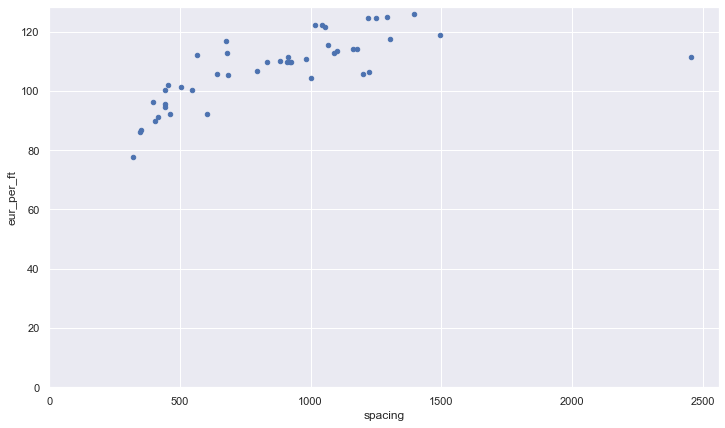

In [6]:
df.plot.scatter(x='spacing', y='eur_per_ft')
plt.xlim(0,)
plt.ylim(0,)

fit: k: 0.00443 
     L: 174.16 
     b0: 29.31


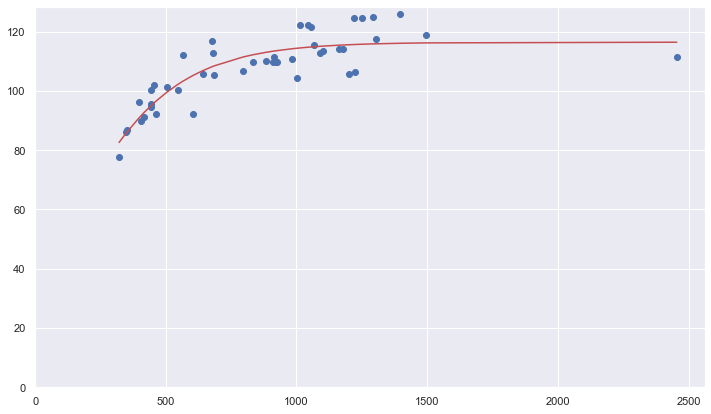

In [13]:
y = np.array(df['eur_per_ft'].values)
x = df['spacing'].values

popt, _ = curve_fit(cost, x, np.log(y),
                   bounds=([0, 70, 0], [.1, 200, 100]))

plt.scatter(x=x, y=y)
plt.plot(x, mod_sig(x, *popt), color='r')

plt.xlim(0,)
plt.ylim(0,)

print('fit: k: %1.5f \n     L: %1.2f \n     b0: %1.2f' % tuple(popt))

(array([ 1.,  3.,  0.,  4., 12.,  9.,  3.,  2.,  4.,  7.]),
 array([-12.9047797 , -10.62423066,  -8.34368163,  -6.06313259,
         -3.78258356,  -1.50203452,   0.77851451,   3.05906355,
          5.33961258,   7.62016162,   9.90071065]),
 <BarContainer object of 10 artists>)

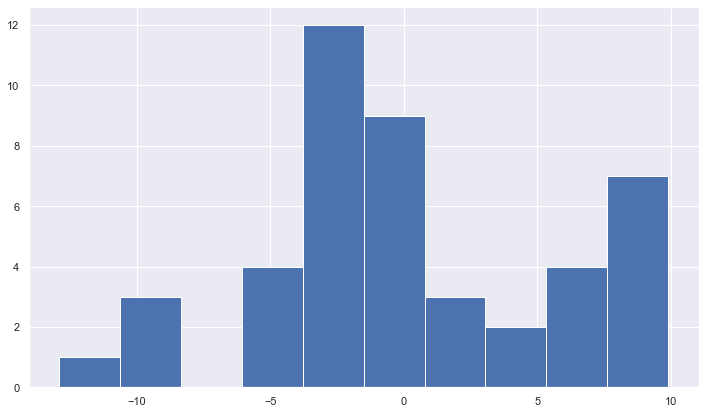

In [16]:
resid = y - mod_sig(x, *popt)

plt.hist(resid)